In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os, sys
import numpy as np
from tqdm import tqdm
import logging
from gym.wrappers import RecordVideo
import text_flappy_bird_gym
from collections import defaultdict
from IPython.display import clear_output
from copy import deepcopy

import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.Agent import DQAgent, QAgent, SarsaAgent

In [4]:
!mkdir logs
logging.basicConfig(filename='logs/flappy-bird.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Flappy-Bird problem

State : 

* Observations : Distance from pipe (dx,dy)
* Actions : 2 (jump or nothing)

In [5]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()


In [6]:
obs

((13, -4), {'score': 0, 'player': [6, 7], 'distance': 13.601470508735444})

In [7]:
next_state, reward, done, truncated, info = env.step(1)

In [8]:
reward, done, truncated

(1, False, False)

In [9]:
sys.stdout.write(env.render())

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-5)


580

## Agent class

In [22]:
episodes = 100000
history = {
    "Q-Learning":[],
    "SARSA": []
}

losses = {
    "Q-Learning":[],
    "SARSA": []
}

agents = {
    "Q-Learning": QAgent(2, 2, gamma= 1),
    "SARSA": SarsaAgent(2, 2, gamma=1)
}

best_models = {
    "Q-Learning":[],
    "SARSA": []
}

best_score = {
    "Q-Learning": 0,
    "SARSA": 0
}

for agent_name, agent in agents.items():
    for e in tqdm(range(episodes)):
        loss_epoch = []
        state, _ = env.reset()
        count = 0
        # Play the game!
        while True:
            count += 1
            # Run agent on the state
            
            action = agent.act(state)

            # Agent performs action
            next_state, reward, done, trunc, info = env.step(action)


            # Check if end of game
            if done or trunc:
                if info['score'] > best_score[agent_name]:
                    best_score[agent_name] = info['score']
                    best_models[agent_name]= deepcopy(agent)

                history[agent_name].append(info['score'])
                # logging.info(f"Game ended")
                count = 0
                break

            next_action = agent.act(next_state)

            # Learn
            loss = agent.learn(state,
                        next_state,
                        action,
                        reward,
                        next_action)
            
            loss_epoch.append(loss)

            # Update state
            state = next_state

        losses[agent_name].append(np.mean(loss_epoch))

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:09<00:00, 1435.00it/s]


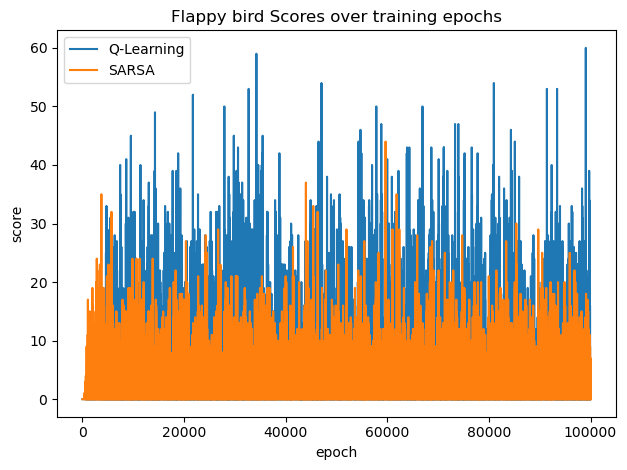

In [23]:
for model_name in history.keys():
    plt.plot(history[model_name],
             label = model_name)

plt.legend()
plt.title("Flappy bird Scores over training epochs")
plt.xlabel("epoch")
plt.ylabel("score")
plt.tight_layout()
plt.savefig("img/flappy_bird_TD.png")

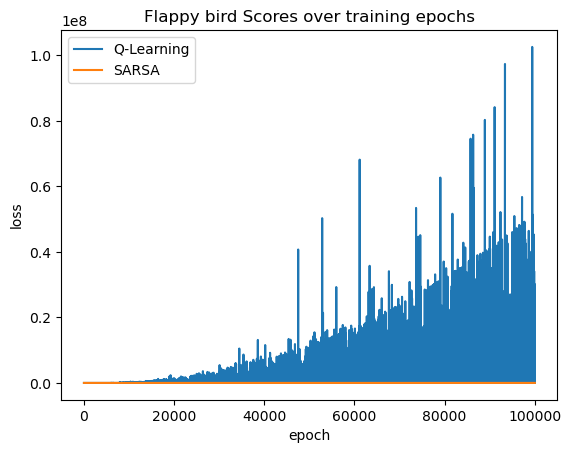

In [24]:
for model_name in losses.keys():
    plt.plot(losses[model_name],
             label = model_name)

plt.legend()
plt.title("Flappy bird Scores over training epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("img/flappy_bird_TD_loss.png")

In [69]:
episodes = 200
history_dqn = []
best_score = 0
best_model = None
dq_agent = DQAgent(2,2, "cpu", )
for e in tqdm(range(episodes)):

    state, _ = env.reset()
    # Play the game!
    while True:
        # Run agent on the state
        
        action = dq_agent.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        if info['score'] >100:
            done = True
        
        if done or trunc:
            next_state = None
        # Remember
        dq_agent.save_to_memory(state, next_state, action, reward,)

        # Learn
        loss = dq_agent.learn()

        # # Loggings
        # logging.info(loss)

        dq_agent.update_networks()

        # Update state
        state = next_state

        if info['score']>= best_score:
            best_score = info['score']
            best_model = deepcopy(dq_agent.policy_dqn)

        # Check if end of game

        if done or trunc:
            history_dqn.append(info['score'])
            logging.info(f"Game ended. Score = {info['score']}")
            count = 0
            break

dq_agent.policy_dqn = best_model

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


In [58]:
sum(p.numel() for p in dq_agent.policy_dqn.parameters() if p.requires_grad)

17154

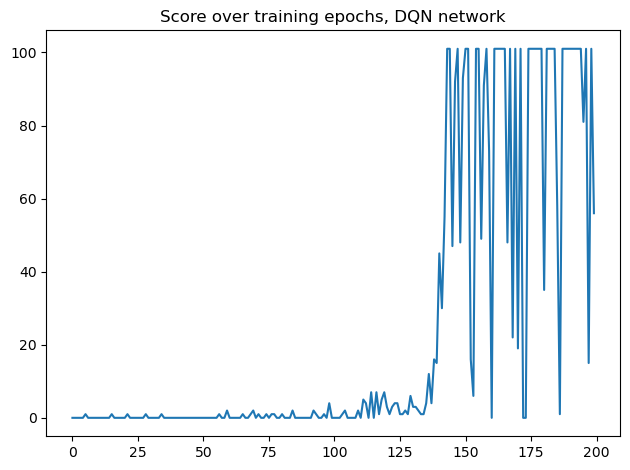

In [70]:
plt.plot(history_dqn)
plt.title("Score over training epochs, DQN network")
plt.tight_layout()
plt.savefig("dqn_train.png")

## Test

In [73]:
n_epochs = 200

history_test = {
    "Q-Learning":[],
    "SARSA": [],
    "DQN": []
}

history_test['Q-Learning'] = []
history_test['SARSA'] = []

for name, _ in agents.items():
    for i in range(n_epochs):
        state, info = env.reset()
        while True:
            agent = best_models[name]
            # Select next action
            agent.epsilon = 0
            action = agent.act(state)  # for an agent, action = agent.policy(observation)

            # Appy action and return new observation of the environment
            state, reward, done, _, info = env.step(action)

            # Render the game
            # clear_output(wait= True)
            # sys.stdout.write(env.render())
            # time.sleep(0.15) # FPS

            # If player is dead break
            if done or info['score']> 100:
                history_test[name].append(info['score'])
                break

            env.close()

dq_agent.epsilon = 0
dq_agent.final_epsilon = 0
for i in tqdm(range(n_epochs)):

    state, info = env.reset()
        
    while True:

        # Select next action
        
        action = dq_agent.act(state)  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        state, reward, done, _, info = env.step(action)

        # Render the game
        # clear_output(wait= True)
        # sys.stdout.write(env.render())
        # time.sleep(0.2) # FPS

        # If player is dead break
        if done or info['score']>=100:
            history_test['DQN'].append(info['score'])
            break

        env.close()


100%|██████████| 200/200 [00:31<00:00,  6.45it/s]


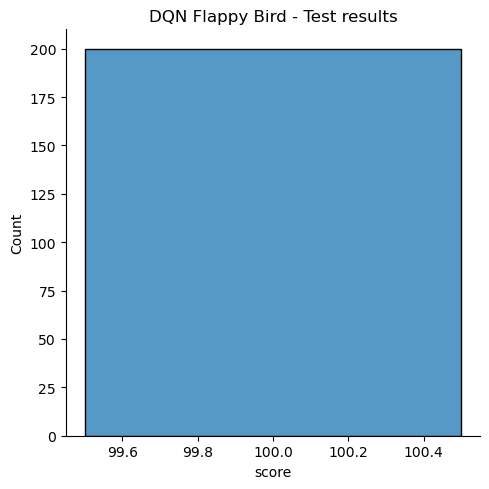

In [72]:
sns.displot(history_test['DQN'],)
plt.title("DQN Flappy Bird - Test results")
plt.xlabel("score")
plt.tight_layout()
plt.savefig("img/dqn_test.png")

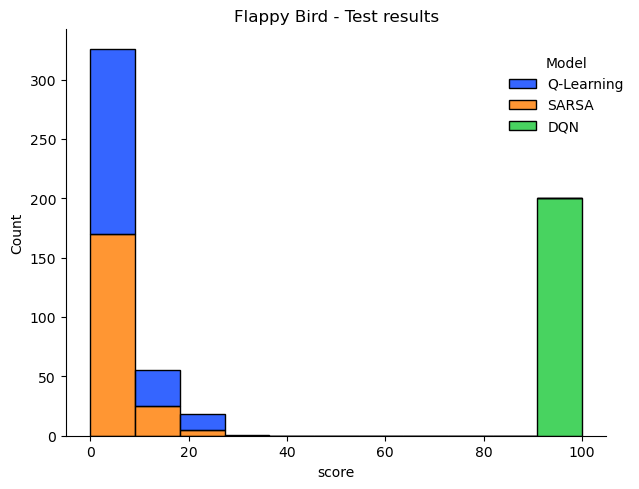

In [86]:
g = sns.displot(history_test, 
            palette="bright",
            alpha=0.8,
            multiple = 'stack',
            legend= True,)
sns.move_legend(g, "upper left", bbox_to_anchor=(.8, .9), title='Model')
plt.title("Flappy Bird - Test results")
plt.xlabel("score")
plt.tight_layout()
# plt.show()
plt.savefig("img/flappy_bird_test.png")